In [16]:
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import umap
from torch.nn.functional import mse_loss
from tqdm import tqdm
from sklearn.decomposition import PCA

from autoencoder import NonLinearAutoencoder, LinearAutoencoder
from solver import *

In [17]:
avg_losses = []
for ae_type in ['sae', 'dae']:
    last_losses = []
    
    for model_id in range(10):
        file_path = f'/home/david/mnist_model/{ae_type}/{model_id}/all_train_losses.npy'
        losses = np.load(file_path)
        # Average loss in the last training epoch
        last_loss = np.mean(losses[-1])
        last_losses.append(last_loss)
    
    avg_losses.append(np.mean(last_losses))

for ae_type, avg_loss in zip(['SAE', 'DAE'], avg_losses):
    print(f"{ae_type}: Average Training Loss = {avg_loss:.5f}")

SAE: Average Training Loss = 0.09279
DAE: Average Training Loss = 0.09650


In [18]:
# MNIST normalisation
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [19]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'sae':
        model = NonLinearAutoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = NonLinearAutoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [20]:
average_last_losses = {}
for ae_type in ['sae', 'dae']:
    last_losses = []
    
    for model_id in range(10):
        file_path = f'/home/david/mnist_model/{ae_type}/{model_id}'
        model = load_model(file_path, ae_type, 49)
        # Average loss in the last training epoch
        test_loss, _, _ = test(model, test_loader, device='cpu')
        last_losses.append(test_loss)
    
    average_last_losses[ae_type] = np.mean(last_losses)

for ae_type, avg_loss in average_last_losses.items():
    print(f"{ae_type}: Average Test Loss = {avg_loss:.5f}")

/tmp/ipykernel_195540/366761175.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_epoch{epoch}.pth")
/home/david/Documen

====> Test set loss: 0.0953
====> Test set loss: 0.0965
====> Test set loss: 0.0935
====> Test set loss: 0.1004
====> Test set loss: 0.0984
====> Test set loss: 0.1052
====> Test set loss: 0.0981
====> Test set loss: 0.0950
====> Test set loss: 0.0954
====> Test set loss: 0.0922
====> Test set loss: 0.1068
====> Test set loss: 0.1083
====> Test set loss: 0.1067
====> Test set loss: 0.0999
====> Test set loss: 0.1033
====> Test set loss: 0.0982
====> Test set loss: 0.1018
====> Test set loss: 0.1019
====> Test set loss: 0.1044
====> Test set loss: 0.1072
sae: Average Test Loss = 0.09700
dae: Average Test Loss = 0.10385


In [21]:
def count_autoencoder_params(layers):
    total_params = 0
    
    for i in range(len(layers) - 1):
        weights = layers[i] * layers[i + 1]  # Connections between layers
        biases = layers[i + 1]  # Bias for each neuron in the next layer
        total_params += weights + biases
    
    return total_params

sae_size_ls = [32, 32, 32, 32, 32, 32,
    32, 32, 32, 32, 32, 32,
    32, 32, 32, 32, 32, 32,
    32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32,
    32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32,]

dae_size_ls = [4, 4, 4, 4, 4, 10,
    10, 10, 10, 10, 16, 16,
    16, 16, 16, 16, 16, 24,
    24, 24, 24, 24, 24, 24, 
    32, 32, 32, 32, 32, 32,
    32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32,]

bottleneck_parameters = []
for bottleneck_size in sae_size_ls:
    layers = [784, 512, 128, bottleneck_size, 128, 512, 784]
    params = count_autoencoder_params(layers)
    bottleneck_parameters.append(params)

sae_cumulative_params = np.cumsum(bottleneck_parameters)

bottleneck_parameters = []
for bottleneck_size in dae_size_ls:
    layers = [784, 512, 128, bottleneck_size, 128, 512, 784]
    params = count_autoencoder_params(layers)
    bottleneck_parameters.append(params)

dae_cumulative_params = np.cumsum(bottleneck_parameters)

In [22]:
def get_train_loss_per_epoch(model_type, num_models = 10):
    model_losses = []
    
    for model_id in range(num_models):
        file_path = f'/home/david/mnist_model/{model_type}/{model_id}/'
        train_losses = np.load(file_path + 'all_train_losses.npy')
        avg_train_loss_epoch = np.mean(train_losses, axis=1)

        # Convert MSE to RMSE
        rmse_normalized = np.sqrt(avg_train_loss_epoch)
        # Denormalize RMSE
        rmse_original = rmse_normalized * 0.3081
        # Convert back to MSE
        avg_train_loss_epoch = rmse_original ** 2

        model_losses.append(avg_train_loss_epoch)
    
    model_losses_array = np.array(model_losses)

    return model_losses_array

In [23]:
def get_average_train_loss(model_type, num_models = 10):
    model_losses = []
    
    for model_id in range(num_models):
        file_path = f'/home/david/mnist_model/{model_type}/{model_id}/'
        train_losses = np.load(file_path + 'all_train_losses.npy')
        train_losses = np.concatenate(train_losses)

        # Convert MSE to RMSE
        rmse_normalized = np.sqrt(train_losses)
        # Denormalize RMSE
        rmse_original = rmse_normalized * 0.3081
        # Convert back to MSE
        train_losses = rmse_original ** 2

        model_losses.append(train_losses)
    
    model_losses_array = np.array(model_losses)

    return model_losses_array

In [ ]:
def plot_accuracy_over_epochs(sae_train_loss, dae_train_loss):
    sae_mean = np.mean(sae_train_loss, axis=0)
    sae_std = np.std(sae_train_loss, axis=0)
    dae_mean = np.mean(dae_train_loss, axis=0)
    dae_std = np.std(dae_train_loss, axis=0)

    plt.rc('font', size=16)
    plt.figure(figsize=(6, 4), dpi=300)
    
    plt.plot(sae_mean, label='AE', color='blue', linewidth=2)
    plt.fill_between(range(len(sae_train_loss[0])), 
                     sae_mean - sae_std, 
                     sae_mean + sae_std, 
                     color='blue', alpha=0.2)
    
    plt.plot(dae_mean, label='Dev-AE', color='red', linewidth=2)
    plt.fill_between(range(len(sae_train_loss[0])), 
                     dae_mean - dae_std, 
                     dae_mean + dae_std, 
                     color='red', alpha=0.2)
        
    plt.xticks([0, 29, 59], [1, 30, 60])
    plt.yticks([0, 0.1])
    plt.xlabel('Epochs Trained')
    plt.ylabel('MSE Loss')
    plt.title('Average Training Loss Over Epochs', pad=20)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend()
    plt.tight_layout()

    plt.savefig('Plots_svg/accuracy_over_epochs.svg', bbox_inches='tight', dpi=300)
    plt.savefig('Plots_png/accuracy_over_epochs.png', bbox_inches='tight')
    plt.show()

In [46]:
def plot_accuracy_over_training_steps(sae_train_loss, dae_train_loss):
    sae_mean = np.mean(sae_train_loss, axis=0)
    sae_std = np.std(sae_train_loss, axis=0)
    dae_mean = np.mean(dae_train_loss, axis=0)
    dae_std = np.std(dae_train_loss, axis=0)


    plt.rc('font', size=16)
    plt.figure(figsize=(6, 4), dpi=300)
    
    plt.plot(sae_mean, label='AE', color='blue', linewidth=2)
    plt.fill_between(range(len(sae_train_loss[0])), 
                     sae_mean - sae_std, 
                     sae_mean + sae_std, 
                     color='blue', alpha=0.2)
    
    plt.plot(dae_mean, label='Dev-AE', color='red', linewidth=2)
    plt.fill_between(range(len(sae_train_loss[0])), 
                     dae_mean - dae_std, 
                     dae_mean + dae_std, 
                     color='red', alpha=0.2)
    
    plt.xticks([0, 10000, 20000])
    plt.yticks([0, 0.1])
    plt.xlabel('Training Steps')
    plt.ylabel('MSE Loss')
    plt.title('Average Training Loss Over Training Steps', pad=20)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend()
    plt.tight_layout()

    plt.savefig('Plots_svg/accuracy_over_training_steps.svg', bbox_inches='tight')
    plt.savefig('Plots_png/accuracy_over_training_steps.png', bbox_inches='tight', dpi=300)
    plt.show()

In [47]:
def plot_accuracy_over_parameters(sae_train_loss, dae_train_loss):
    sae_mean = np.mean(sae_train_loss, axis=0)
    sae_std = np.std(sae_train_loss, axis=0)
    dae_mean = np.mean(dae_train_loss, axis=0)
    dae_std = np.std(dae_train_loss, axis=0)

    plt.rc('font', size=16)
    plt.figure(figsize=(6, 4), dpi=300)
    
    plt.plot(sae_cumulative_params, sae_mean, label='AE', color='blue', linewidth=2)
    plt.fill_between(sae_cumulative_params, 
                     sae_mean - sae_std, 
                     sae_mean + sae_std, 
                     color='blue', alpha=0.2)
    
    plt.plot(dae_cumulative_params, dae_mean, label='Dev-AE', color='red', linewidth=2)
    plt.fill_between(dae_cumulative_params, 
                     dae_mean - dae_std, 
                     dae_mean + dae_std, 
                     color='red', alpha=0.2)
    
    plt.xticks([0, 2e7, 4e7], ["0", "2×10⁷", "4×10⁷"])
    plt.yticks([0, 0.1])
    plt.xlabel('Cumulative Parameters')
    plt.ylabel('MSE Loss')
    plt.title('Average Training Loss Over Cumulative Parameters', pad=20)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend()
    plt.tight_layout()

    plt.savefig('Plots_svg/accuracy_over_parameters.svg', bbox_inches='tight')
    plt.savefig('Plots_png/accuracy_over_parameters.png', bbox_inches='tight', dpi=300)
    plt.show()

In [48]:
def create_plots():
    sae_train_loss = get_train_loss_per_epoch('sae')
    dae_train_loss = get_train_loss_per_epoch('dae')
    plot_accuracy_over_epochs(sae_train_loss, dae_train_loss)
    plot_accuracy_over_parameters(sae_train_loss, dae_train_loss)

    sae_train_loss = get_average_train_loss('sae')
    dae_train_loss = get_average_train_loss('dae')
    plot_accuracy_over_training_steps(sae_train_loss, dae_train_loss)

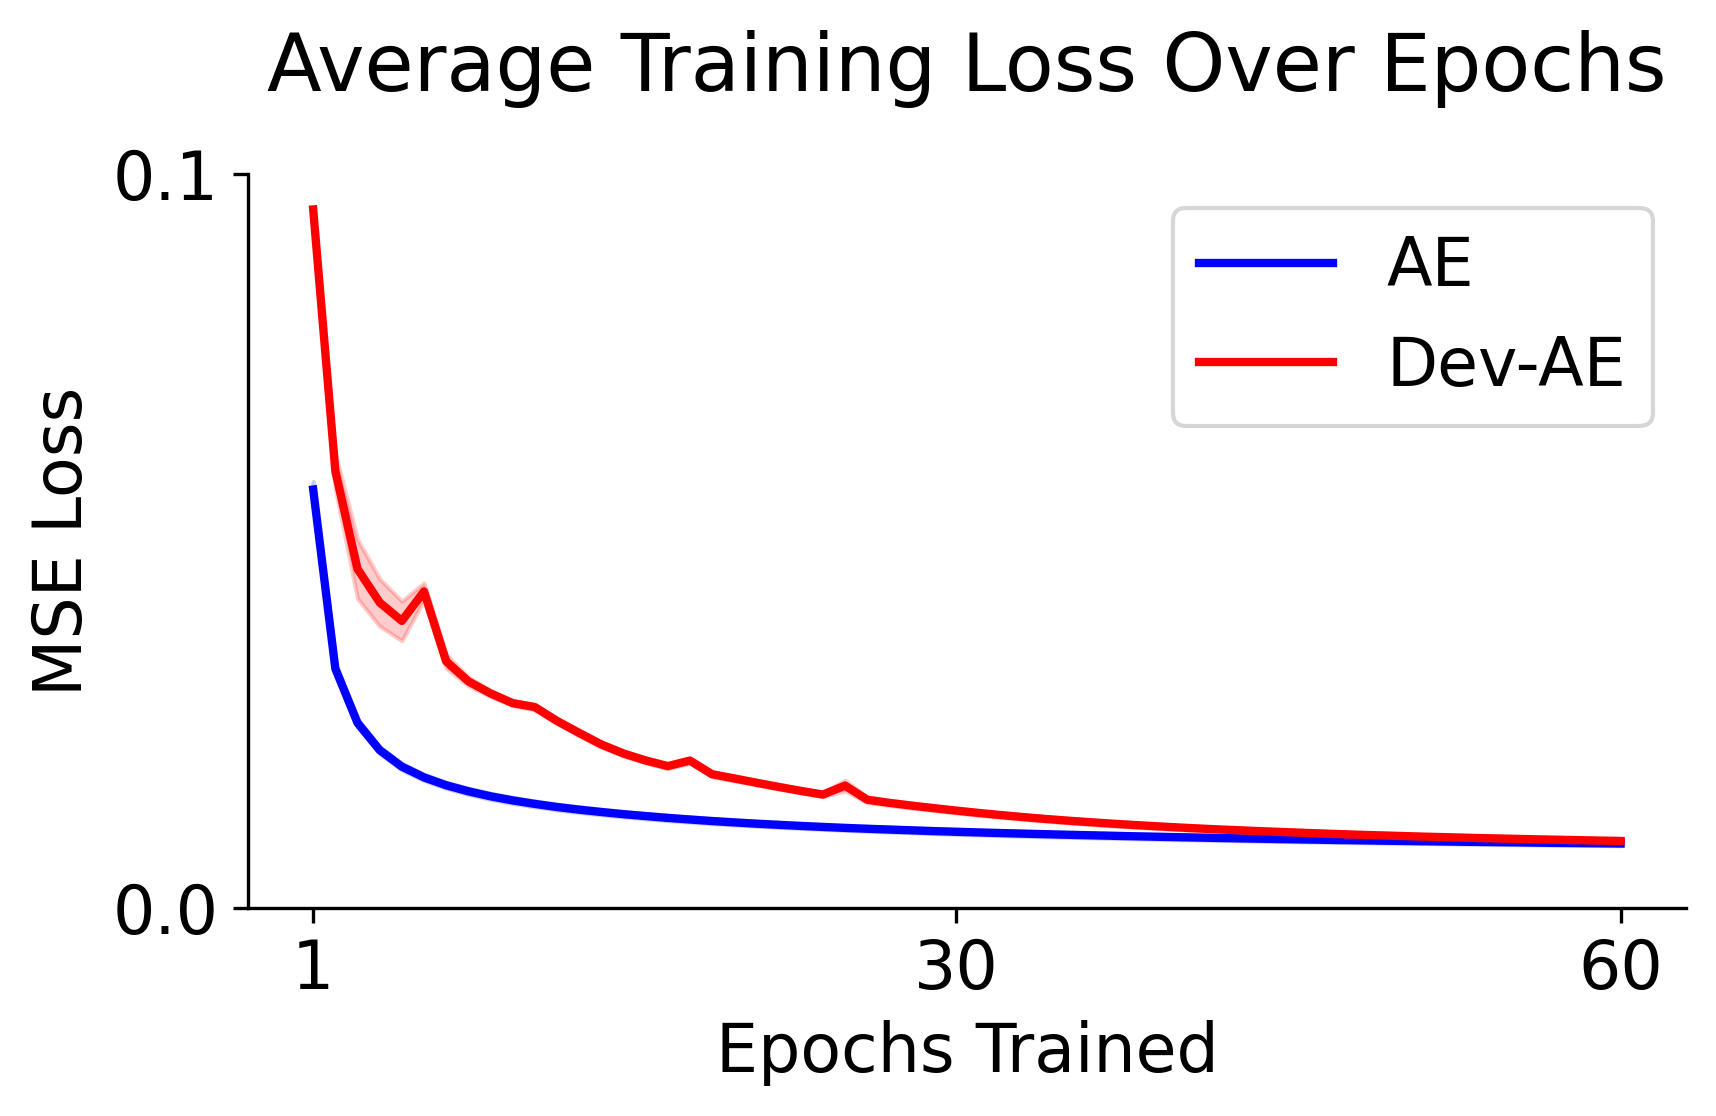

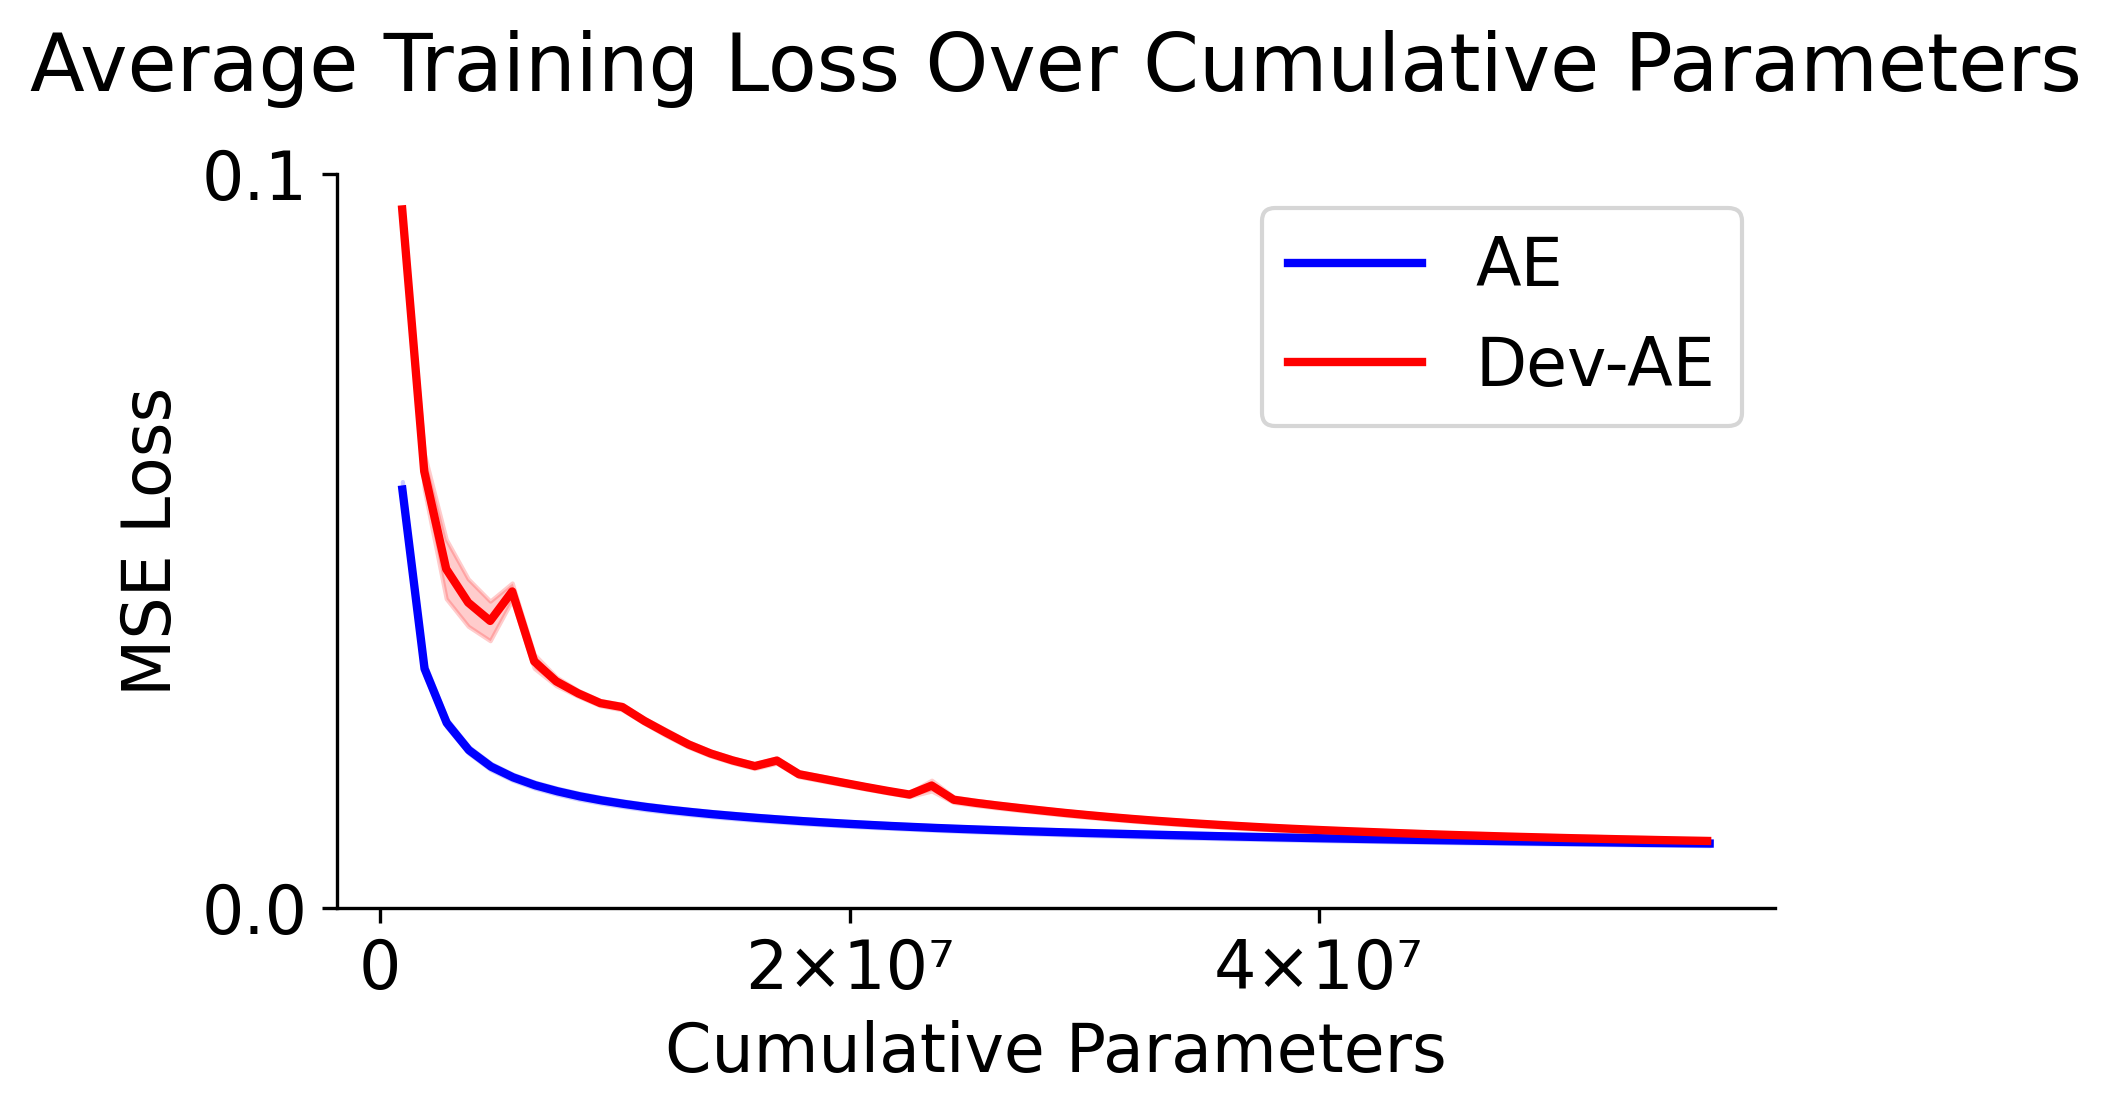

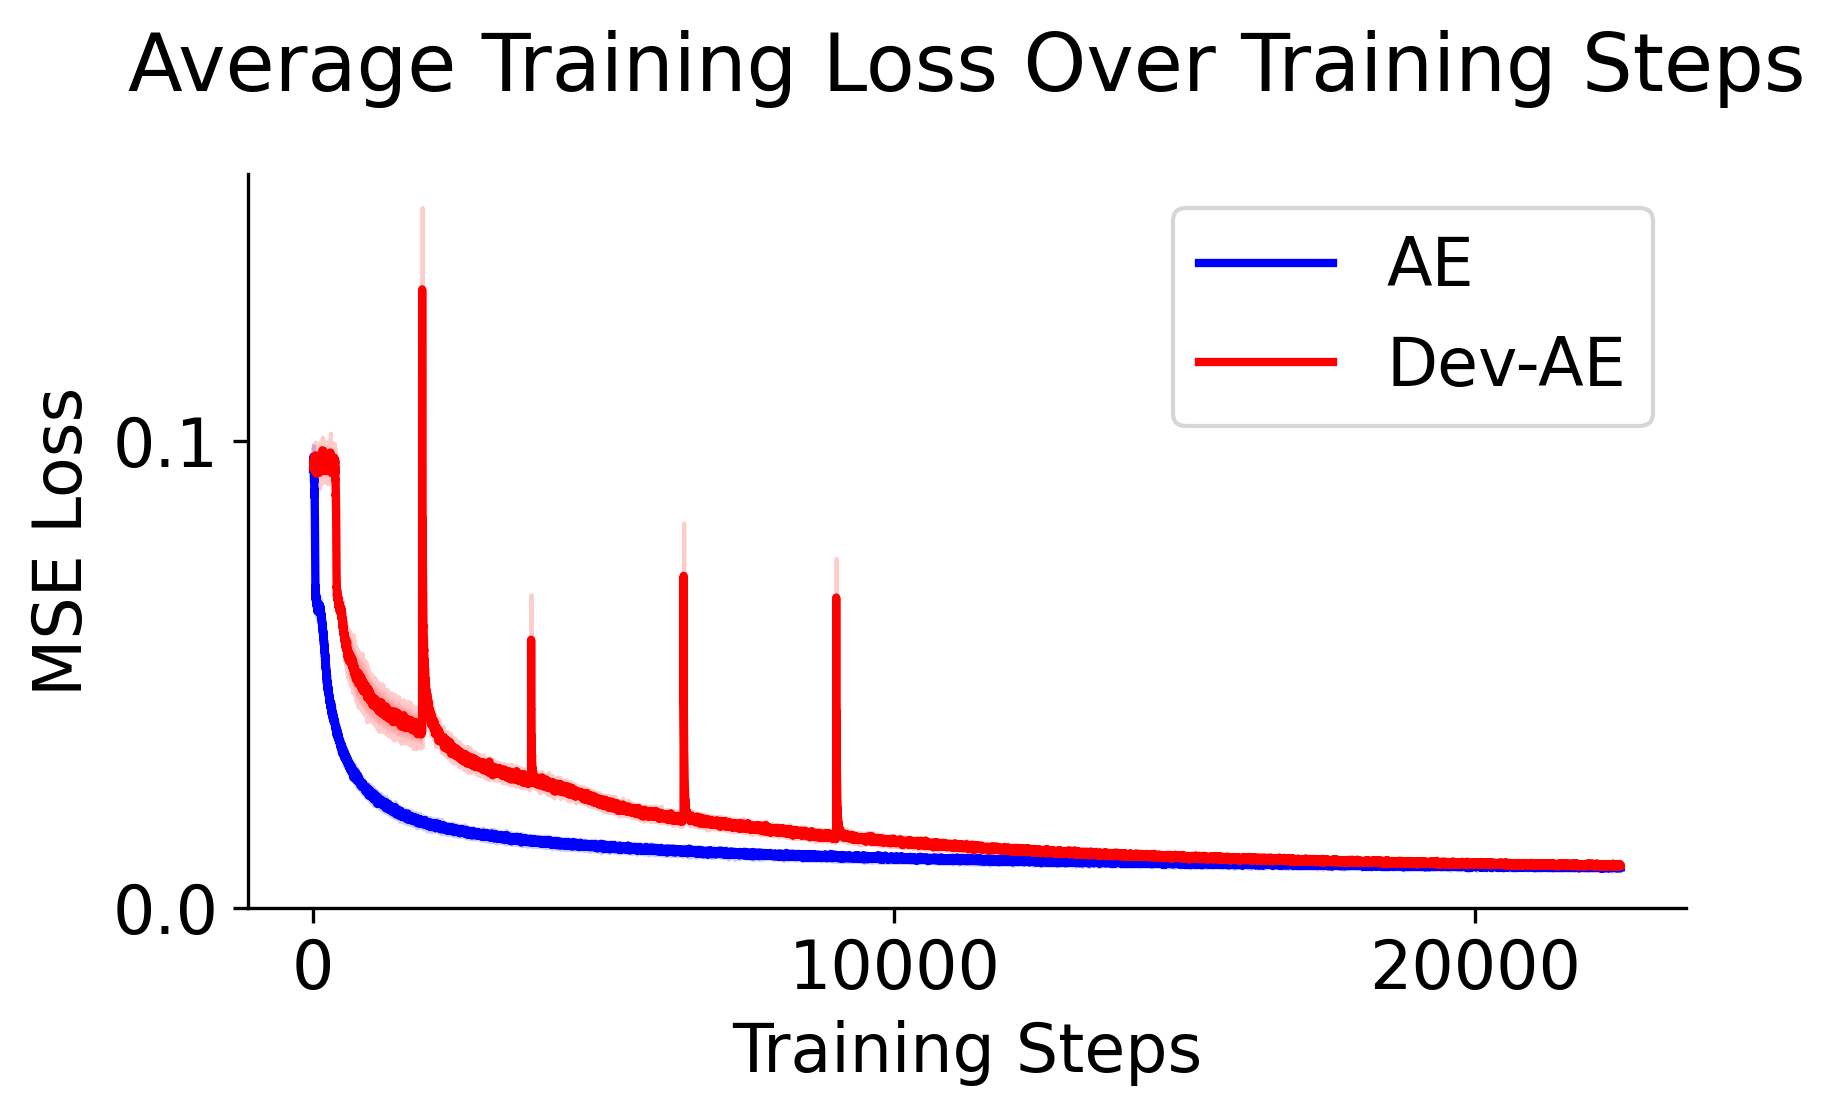

In [49]:
create_plots()